In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from joblib import Parallel, delayed
from tqdm import tqdm

plt.rc('font', family='serif', serif='Times New Roman')

all_data = np.load('all_data_results.npz')
h0_min_sne_all = all_data['h0_min_sne_all']
omm_min_sne_all = all_data['omm_min_sne_all']
h0_std_sne_all = all_data['h0_std_sne_all']
omm_std_sne_all = all_data['omm_std_sne_all']
h0_min_bao_all = all_data['h0_min_bao_all']
omm_min_bao_all = all_data['omm_min_bao_all']
h0_std_bao_all = all_data['h0_std_bao_all']
omm_std_bao_all = all_data['omm_std_bao_all']
param_all = all_data['param_all']

In [2]:
# may ignore this part if only want to change the plot
def calculate_om0_distributions(x, omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao, weights=None, n_jobs=-1):
    total_subtraction = np.zeros_like(x)

    combined_data = np.column_stack((omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao))

    out_of_range_mask = (combined_data[:, 0] < 0.003) | (combined_data[:, 0] > 0.997) | \
                        (combined_data[:, 1] < 0.003) | (combined_data[:, 1] > 0.997)

    combined_data[out_of_range_mask, :2] = np.nan
    omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao = combined_data.T

    def process_single(mu_sne, mu_bao, sigma_sne, sigma_bao, weight):
        if not np.isnan(mu_sne) and not np.isnan(mu_bao) and not np.isnan(sigma_sne) and not np.isnan(sigma_bao):
            return weight * norm.pdf(x, mu_sne - mu_bao, (sigma_sne ** 2 + sigma_bao ** 2) ** 0.5)
        return np.zeros_like(x)

    if weights is not None:
        weights = np.array(weights)
        if weights.size != len(omm_min_sne):
            raise ValueError("Weights need same with #parameters")
        else:
            weights = weights / np.sum(weights)
            results = Parallel(n_jobs=n_jobs)(
                delayed(process_single)(mu_sne, mu_bao, sigma_sne, sigma_bao, weight)
                for mu_sne, mu_bao, sigma_sne, sigma_bao, weight in
                tqdm(zip(omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao, weights), total=len(weights))
            )
    else:
        results = Parallel(n_jobs=n_jobs)(
            delayed(process_single)(mu_sne, mu_bao, sigma_sne, sigma_bao, 1.0)
            for mu_sne, mu_bao, sigma_sne, sigma_bao in
            tqdm(zip(omm_min_sne, omm_min_bao, omm_std_sne, omm_std_bao), total=len(omm_min_sne))
        )

    for result in results:
        total_subtraction += result

    return total_subtraction

In [3]:
def plot_delta_omm(dataname, omm_min_sne_all, omm_min_bao_all, omm_std_sne_all, omm_std_bao_all, x_vals=np.linspace(-0.4, 0.4, 1000)):
    y_vals = calculate_om0_distributions(x_vals, omm_min_sne_all, omm_min_bao_all, omm_std_sne_all, omm_std_bao_all)
    y_vals = y_vals / np.trapz(y_vals, x_vals) 

    plot_the_domm_plot(x_vals, y_vals, dataname)
    
def plot_the_domm_plot(x_vals, y_vals, dataname_file_string):
    peak_index = np.argmax(y_vals)
    peak_x = x_vals[peak_index]
    peak_y = y_vals[peak_index]

    mean = np.trapz(x_vals * y_vals, x_vals)

    variance = np.trapz((x_vals - mean) ** 2 * y_vals, x_vals)

    std_dev = np.sqrt(variance)

    print(f'Peak: {peak_x:.4f}')
    print(f'Mean: {mean:.4f}')
    print(f'Standard Deviation: {std_dev:.4f}')

    plt.figure(figsize=(10, 6), dpi=300)
    plt.plot(x_vals, y_vals, color='black', label=r'$\Omega_{m, \text{SNe}} - \Omega_{m, \text{BAO}}$ ' + dataname_file_string)
    #plt.axvline(peak_x, color='r', linestyle='--', label=f'Peak at $\\Delta \\Omega_m = {peak_x:.4f}$')
    plt.axvline(0.058, color='r', linestyle='--', label=f'The Observed $\\Delta \\Omega_m = 0.058$ of DESI and DESY5')

    
    ylim = plt.ylim()  
    for i, (sigma, alpha, color) in enumerate(zip([1, 2, 3], [0.3, 0.2, 0.1], ['lightgray', 'darkgray', 'gray'])):
        label = f'1, 2, 3 σ regions' if i == 0 else None 
        plt.fill_betweenx([ylim[0], ylim[1]], mean - sigma * std_dev, mean + sigma * std_dev,
                          color=color, alpha=alpha, label=label)
    
    plt.xlabel(r'$\Delta \Omega_m$', fontsize=14)
    plt.ylim(0, ylim[1])
    plt.gca().get_yaxis().set_visible(False) 
    plt.legend(fontsize=11, loc='upper left')
    plt.tight_layout()  

    plt.savefig('delta_omega_m_plot_all_together_withh.png', format='png', dpi=900)

    plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 11950.99it/s]


Peak: 0.0525
Mean: 0.0370
Standard Deviation: 0.0763


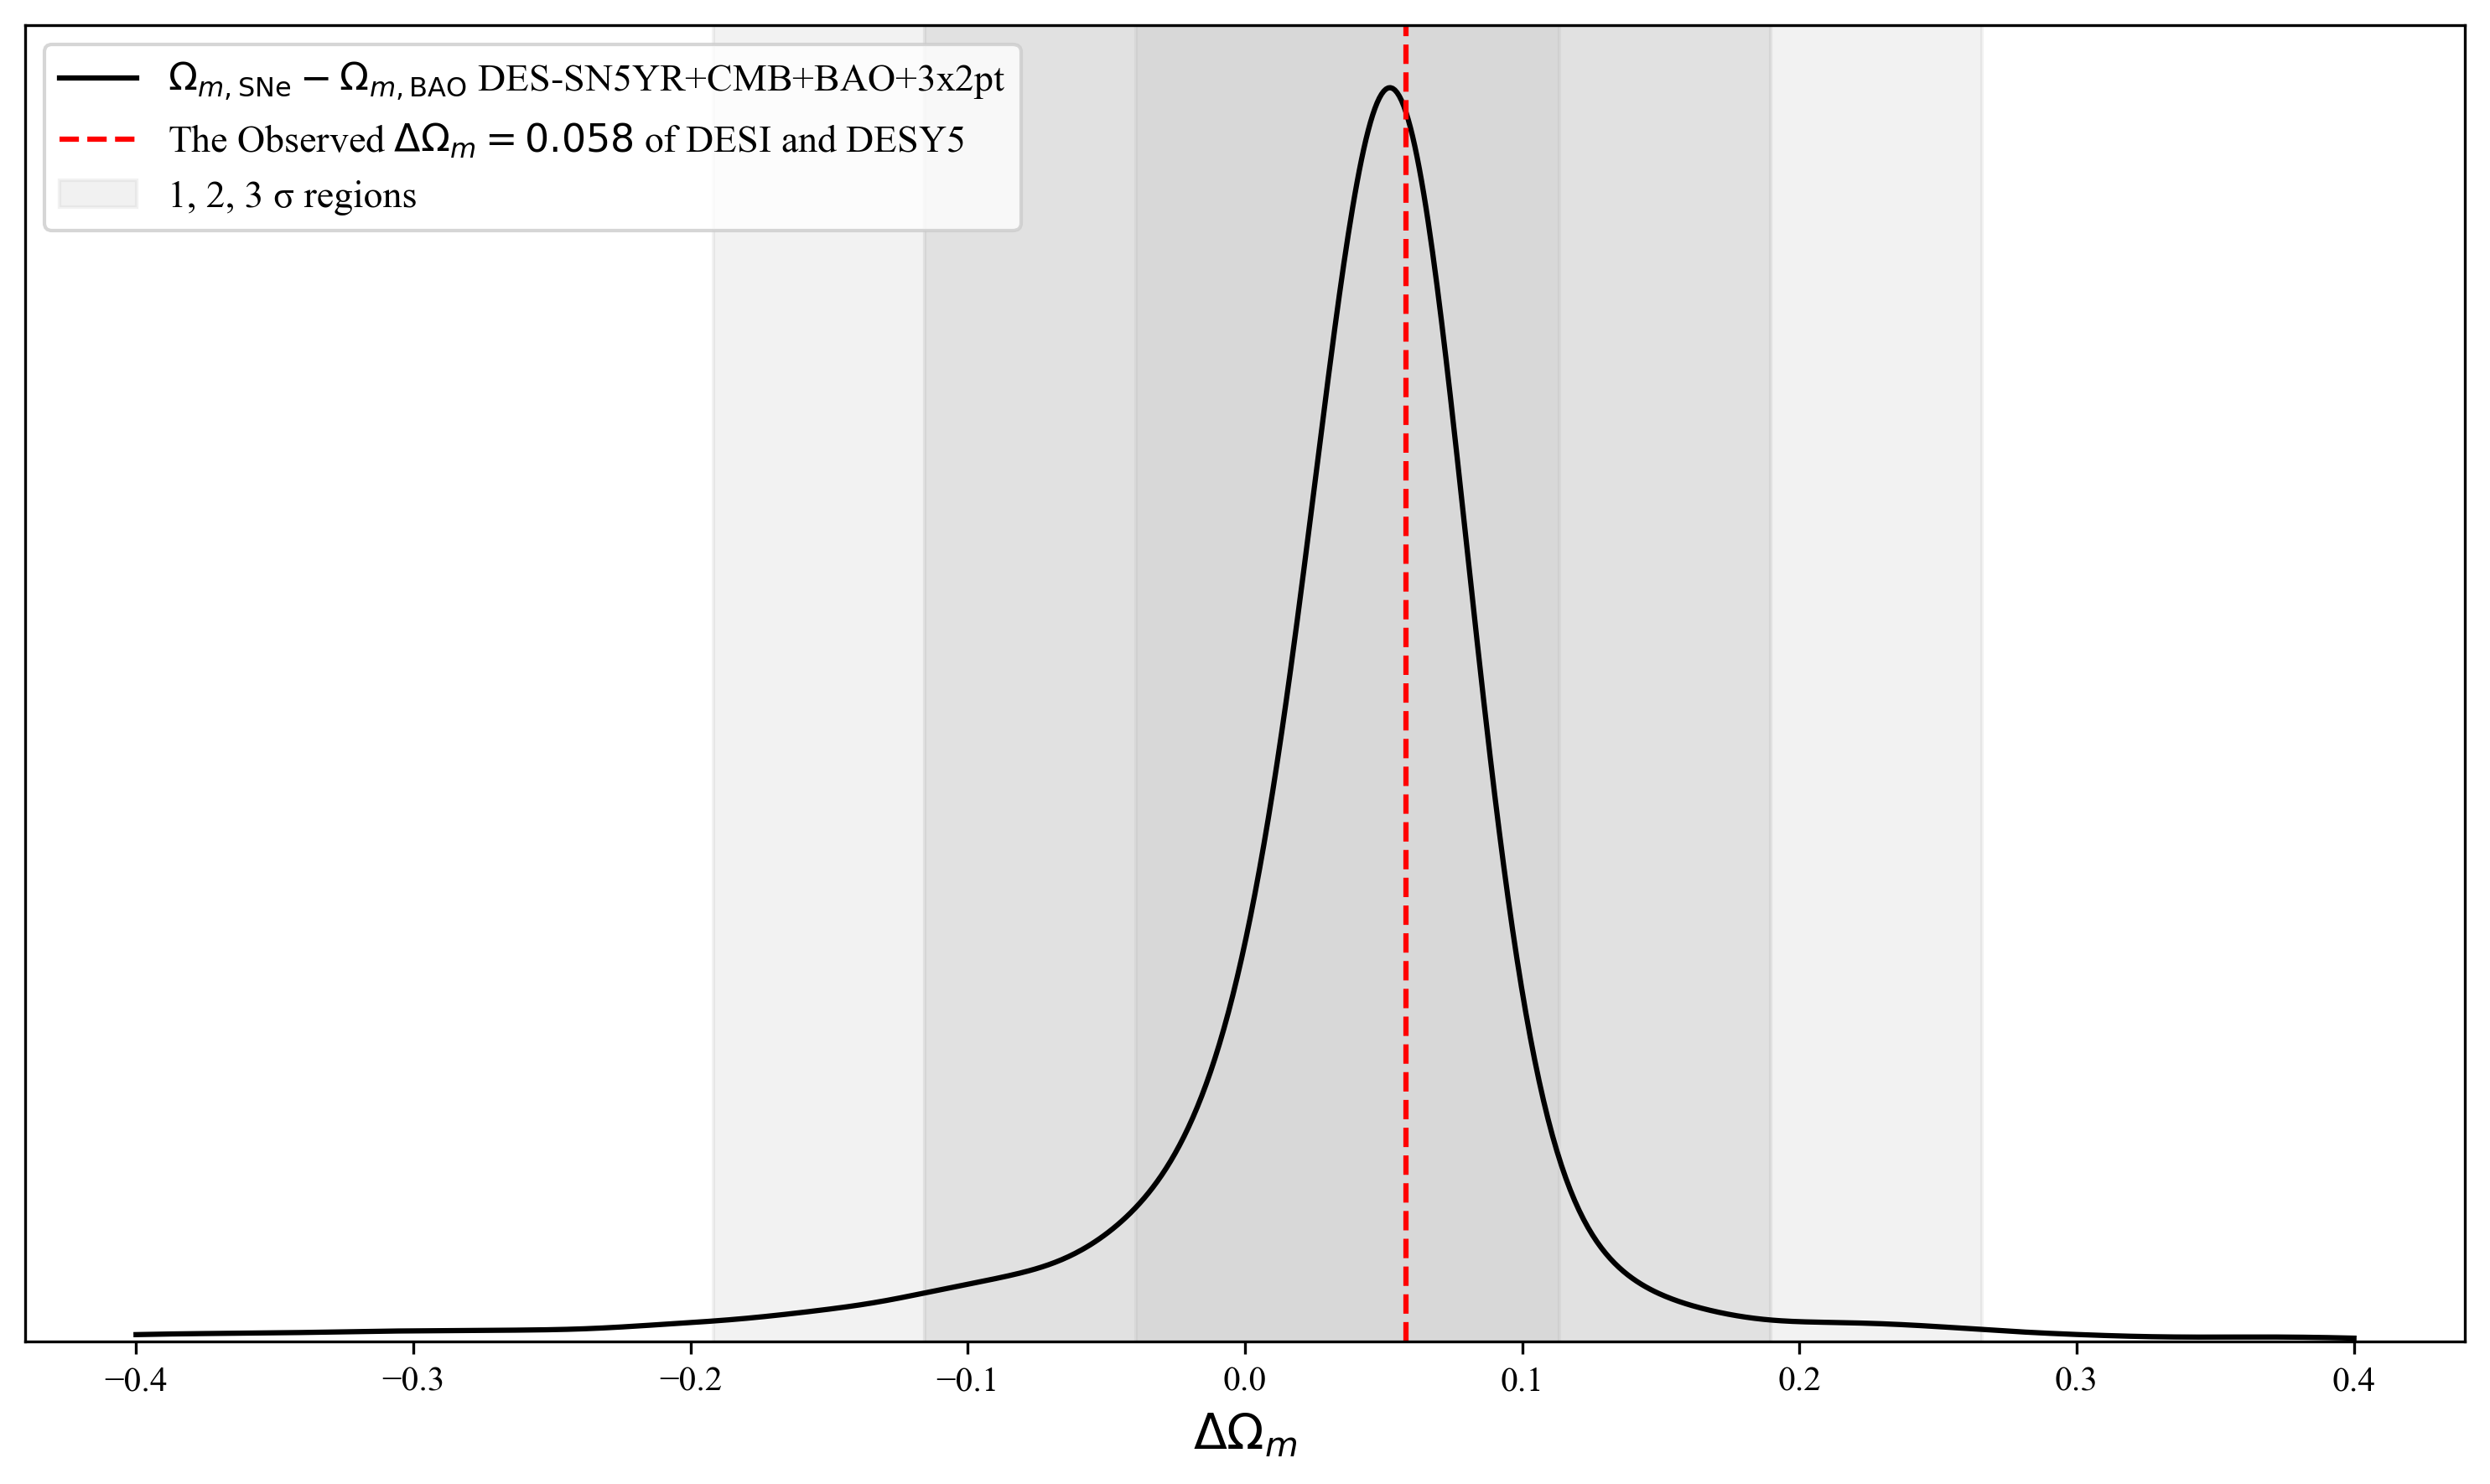

In [4]:
plot_delta_omm('DES-SN5YR+CMB+BAO+3x2pt', omm_min_sne_all, omm_min_bao_all, omm_std_sne_all, omm_std_bao_all)